In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#Import Libraries
import tensorflow as tf
import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import datetime
import time

import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils.vis_utils import plot_model

from sklearn.metrics import recall_score, precision_score
from models import save_model, generate_model_CNN, plot_performance
from generators import generator, decode

Using TensorFlow backend.


In [2]:
save_dir = 'plots'
if not os.path.exists(save_dir):
        os.makedirs(save_dir)

X_load = np.load('../data/processed_data/m4015_session2/X.npy')
Y_load = np.load('../data/processed_data/m4015_session2/y.npy')

res = tf.one_hot(Y_load, depth=2)
with tf.Session() as sess:
    Y_load = (sess.run(res))

split_index = int(X_load.shape[0]*0.8)
    
X_train = X_load[:split_index]
Y_train = Y_load[:split_index]
X_val = X_load[split_index:]
Y_val = Y_load[split_index:]

In [3]:
batch_size = 1000
time_window = 100
n_dim = 1
class_weight = {0: 1., 1: 150.,}
predict_early = 0

input_shape = (time_window, n_dim)

In [4]:
train_generator = generator(X_train, Y_train, batch_size, time_window, predict_early=predict_early)
validate_generator = generator(X_val, Y_val, batch_size, time_window, predict_early=predict_early)

In [5]:
model = generate_model_CNN(input_shape)

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 6)            48        
_________________________________________________________________
average_pooling1d_1 (Average (None, 50, 6)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 12)            516       
_________________________________________________________________
average_pooling1d_2 (Average (None, 25, 12)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 25, 12)            1020      
_________________________________________________________________
average_pooling1d_3 (Average (None, 12, 12)            0         
__________

In [6]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=1000,
                              epochs=10, 
                              verbose=1,
                              validation_data=validate_generator,
                              validation_steps=1000,
                              class_weight=class_weight, )

save_model(model, name=predict_early)

Epoch 1/10
1000/1000 [==============================] - 98s 98ms/step - loss: 0.8155 - acc: 0.8413 - val_loss: 0.1143 - val_acc: 0.9789
Epoch 2/10
1000/1000 [==============================] - 80s 80ms/step - loss: 0.5627 - acc: 0.9260 - val_loss: 0.2389 - val_acc: 0.9347
Epoch 3/10
1000/1000 [==============================] - 86s 86ms/step - loss: 0.5481 - acc: 0.9286 - val_loss: 0.1574 - val_acc: 0.9609
Epoch 4/10
1000/1000 [==============================] - 82s 82ms/step - loss: 0.4967 - acc: 0.9289 - val_loss: 0.1408 - val_acc: 0.9630
Epoch 5/10
1000/1000 [==============================] - 83s 83ms/step - loss: 0.4572 - acc: 0.9334 - val_loss: 0.1849 - val_acc: 0.9500
Epoch 6/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.4711 - acc: 0.9332 - val_loss: 0.2103 - val_acc: 0.9401
Epoch 7/10
1000/1000 [==============================] - 77s 77ms/step - loss: 0.4599 - acc: 0.9320 - val_loss: 0.1964 - val_acc: 0.9507
Epoch 8/10
1000/1000 [==========================

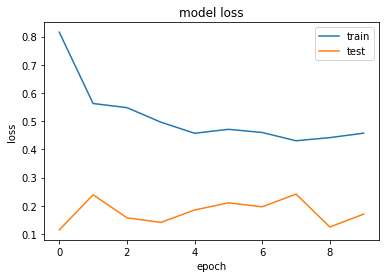

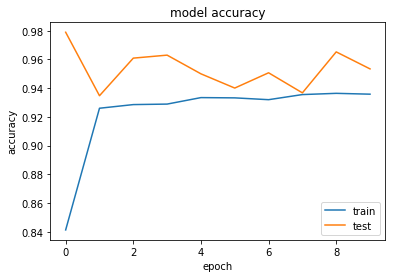

In [7]:
plot_performance(history)

In [8]:
validate_generator = generator(X_val, Y_val, batch_size*10, time_window)

X_trial, y_trial, = next(validate_generator)
res = model.predict(X_trial)

In [9]:
threshold=0.3
y_true = decode(y_trial, threshold=threshold)
y_pred = decode(res, threshold=threshold)

weights = np.zeros_like(y_true)
weights[y_true==0] = 1
weights[y_true==1] = 100


In [10]:
from sklearn.metrics import balanced_accuracy_score, recall_score, classification_report, confusion_matrix

print(balanced_accuracy_score(y_true, y_pred, adjusted=True))
print(recall_score(y_true, y_pred, average='weighted'))

target_names = ['no ripple', 'ripple',]
print(classification_report(y_true, y_pred, target_names=target_names))

0.9027232391933899
0.9243
              precision    recall  f1-score   support

   no ripple       1.00      0.92      0.96      9905
      ripple       0.11      0.98      0.20        95

   micro avg       0.92      0.92      0.92     10000
   macro avg       0.55      0.95      0.58     10000
weighted avg       0.99      0.92      0.95     10000



In [11]:
conv_matrix = confusion_matrix(y_true, y_pred)
print(conv_matrix)
conv_matrix = conv_matrix.astype('float') / conv_matrix.sum(axis=1)[:, np.newaxis]
print(conv_matrix)

[[9150  755]
 [   2   93]]
[[0.92377587 0.07622413]
 [0.02105263 0.97894737]]


In [12]:
# from sklearn.model_selection import TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=5)
# for train_index, test_index in tscv.split(X):
#     print("TRAIN:", train_index, "TEST:", test_index)